In [1]:
# required to be able to import different notebooks
!pip install import-ipynb
import import_ipynb

In [2]:
# important libraries and notebooks
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from utils import (
    get_plane_loader,#return a dataloader of the specific given plane type
    calc_accuracy,
    calc_iou,
    plot_metric,
    save_predictions_as_imgs
)
from model import UNET

importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from dataset.ipynb
importing Jupyter notebook from model.ipynb


In [13]:
# check if your system is runing or cpu or gpu
if torch.cuda.is_available():
    DEVICE = 'cuda:0'
    print('Running on the GPU')
else:
    DEVICE = "cpu"
    print('Running on the CPU')
#important variables
MODEL_PATH = 'model_axial_10.pth.tar'
LOAD_MODEL = True
LEARNING_RATE = 0.001
EPOCHS = 10

Running on the CPU


In [14]:
# this function is to train the model on any plane type images training data, it is called N number of epochs
def train_model(train_data, model, optimizer, loss_fn, device):
    train_loss = [] #hold all the losses based on training data for each patch, then we will get the mean loss for every epoch
    acc = []  #hold all the accuracies based on training data for each patch, then we will get the mean accuracy for every epoch
    ious = [] #hold all the mean ious based on training data for each patch, then we will get the mean iou for every epoch
    data = tqdm(train_data)
    for i, batch in enumerate(data):
        #prepare data
        X, y = batch
        X = X.to(device) 
        y = y.long().squeeze(1).to(device)
        #start training the model
        model.train()
        preds = model(X)
        loss = loss_fn(preds, y)

        train_loss.append(loss.item())
        acc.append(calc_accuracy(preds, y))
        ious.append(calc_iou(y, preds, 3))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = np.mean(train_loss)
    avg_acc = np.mean(acc)
    avg_iou = np.mean(ious)
    return avg_loss, avg_acc, avg_iou, model

In [15]:
# this function is to evaluate the model on a given plane type's validation data, it is called N number of epochs directly after train function
def evaluae_validaion(val_data, model, loss_fn, device):
    val_loss = [] #hold all the losses based on validation data for each patch, then we will get the mean loss for every epoch
    acc = []  #hold all the accuracies based on validation data for each patch, then we will get the mean accuracy for every epoch
    ious = [] #hold all the mean ious based on validation data for each patch, then we will get the mean iou for every epoch
    with torch.no_grad():
        for i, batch in enumerate(tqdm(val_data)):
            #prepare the data for model evaluating
            X, y = batch
            X = X.to(device)
            y = y.long().squeeze(1).to(device)

            model.eval()
            preds = model(X)

            val_loss.append(loss_fn(preds, y).item())
            acc.append(calc_accuracy(preds, y))
            ious.append(calc_iou(y, preds, 3))
      
    avg_loss = np.mean(val_loss)
    avg_acc = np.mean(acc)
    avg_iou = np.mean(ious)
    return avg_loss, avg_acc, avg_iou

In [16]:
# this function combine both train and evaluate functions in one function
def train_val_model(train_data, val_data, model, optimizer, loss_fn, device):
    avg_train_loss, avg_train_acc, avg_train_iou, model_ = train_model(train_data, model, optimizer, loss_fn, device)
    avg_val_loss, avg_val_acc, avg_val_iou = evaluae_validaion(val_data, model_, loss_fn, device)
    return avg_train_loss, avg_train_acc, avg_train_iou, avg_val_loss, avg_val_acc, avg_val_iou

In [17]:
## read the data
##in the next line of code, just write the plane type you wantto train the model on. (axial or coronal or sagittal)
train_loader, val_loader, test_loader = get_plane_loader("axial")

In [22]:
def main():
    global epoch
    epoch = 0 
    avg_loss_train = []
    avg_loss_val = []
    avg_acc_train = []
    avg_acc_val = []
    avg_iou_train = []
    avg_iou_val = []
    
#     train_loader, val_loader, test_loader = get_all_planes_dataloaders()
    print('Data Loaded Successfully!')

    # Defining the model, optimizer and loss function
    unet = UNET(in_channels=1, out_channels=3).to(DEVICE).train()
    optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE)
    loss_function = nn.CrossEntropyLoss() 

    # Loading a previous stored model from MODEL_PATH variable
    if LOAD_MODEL == True:
        checkpoint = torch.load(MODEL_PATH, map_location='cpu')
        unet.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        epoch = checkpoint['epoch']
        avg_loss_train = checkpoint['avg_loss_train']
        avg_acc_train = checkpoint['avg_acc_train']
        avg_iou_train = checkpoint['avg_iou_train']
        avg_loss_val = checkpoint['avg_loss_val']
        avg_acc_val = checkpoint['avg_acc_val']
        avg_iou_val = checkpoint['avg_iou_val']
        print("Model successfully loaded!")    

    #Training the model for every epoch. 
    for e in range(epoch, EPOCHS):
        print('Epoch ' + str(e+1))
        avg_train_loss, avg_train_acc, avg_train_iou, avg_val_loss, avg_val_acc, avg_val_iou =\
         train_val_model(train_loader, val_loader, unet, optimizer, loss_function, DEVICE)
        
        avg_loss_train.append(avg_train_loss)
        avg_acc_train.append(avg_train_acc)
        avg_iou_train.append(avg_train_iou)
        avg_loss_val.append(avg_val_loss)
        avg_acc_val.append(avg_val_acc)
        avg_iou_val.append(avg_val_iou)

        print("epoch: " + str(e+1), " train_loss: " + str(avg_train_loss), " train_acc: " + str(avg_train_acc), " train_iou: ", str(avg_train_iou), \
              " validation_loss: " + str(avg_val_loss), "val_acc: " + str(avg_val_acc), " val_iou: ", str(avg_val_iou))
        #saving the model
        torch.save({
            'model_state_dict': unet.state_dict(),
            'optim_state_dict': optimizer.state_dict(),
            'epoch': e+1,
            'avg_loss_train': avg_loss_train,
            'avg_acc_train': avg_acc_train,
            'avg_iou_train': avg_iou_train,
            'avg_loss_val': avg_loss_val,
            'avg_acc_val': avg_acc_val,
            'avg_iou_val': avg_iou_val
        }, MODEL_PATH)
        print("Epoch completed and model successfully saved!")

    return avg_loss_train, avg_acc_train, avg_iou_train, avg_loss_val, avg_acc_val, avg_iou_val


In [23]:
if __name__ == '__main__':
    avg_loss_train, avg_acc_train, avg_iou_train, avg_loss_val, avg_acc_val, avg_iou_val = main()

Data Loaded Successfully!
Model successfully loaded!


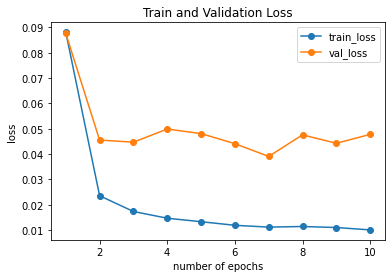

In [24]:
X = list(range(1, len(avg_loss_train)+1))
# 1. plot loss of train and validation data
plot_metric(X, avg_loss_train, avg_loss_val, "train_loss", "val_loss", "number of epochs", "loss", "Train and Validation Loss")

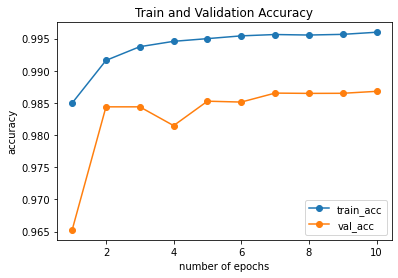

In [25]:
# 2. plot accuracy of train and validation data
plot_metric(X, avg_acc_train, avg_acc_val, "train_acc", "val_acc", "number of epochs", "accuracy", "Train and Validation Accuracy")

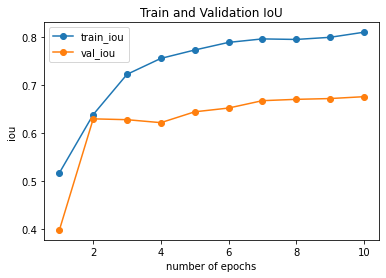

In [26]:
# 3. plot iou of train and validation data
plot_metric(X, avg_iou_train, avg_iou_val, "train_iou", "val_iou", "number of epochs", "iou", "Train and Validation IoU")

# Testing

In [30]:
def get_predictions(data, model):
    loss = []
    acc = []
    ious = []
    loss_function = nn.CrossEntropyLoss()    
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(data)):
            X, y = batch
            X, y = X.to(DEVICE), y.long().squeeze(1).to(DEVICE)
            predictions = model(X)

            loss.append(loss_function(predictions, y).item())
            acc.append(calc_accuracy(predictions, y)) 
            ious.append(calc_iou(y, predictions, 3))

            predictions = torch.nn.functional.softmax(predictions, dim=1)
            pred_labels = torch.argmax(predictions, dim=1) 
            pred_labels = pred_labels.float()
            
            mask_name = "pred_" + str(idx)
            save_predictions_as_imgs(pred_labels, mask_name, "predicted_masks_axial")  
            img_name = "true_" + str(idx)
            save_predictions_as_imgs(y.float(), img_name, "true_masks_axial")
            
    avg_loss = np.mean(loss)
    avg_acc = np.mean(acc)
    avg_iou = np.mean(ious)
    return avg_loss, avg_acc, avg_iou

In [31]:
def test(path, test_data):
    net = UNET(in_channels=1, out_channels=3).to(DEVICE)
    checkpoint = torch.load(path, map_location='cpu')
    net.load_state_dict(checkpoint['model_state_dict'])
    print(f'{path} has been loaded and initialized')
    avg_loss, avg_acc, avg_iou = get_predictions(test_data, net)
    print("Model testing completed...")
    print("loss: ", str(avg_loss), "  accuracy: ", str(avg_acc), " Iou: ", str(avg_iou))

In [32]:
test(MODEL_PATH, test_loader)

model_axial_10.pth.tar has been loaded and initialized


100%|██████████| 91/91 [23:47<00:00, 15.69s/it]

Model testing completed...
loss:  0.07317295418745214   accuracy:  0.9839836961620456  Iou:  0.6221532325859831
